In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/20_newsgroups.tar.gz

In [ ]:
!tar -xf 20_newsgroups.tar.gz

In [18]:
import glob
import os
from random import random
import random
import nltk
import re

**Stop Word**

In [19]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')


[nltk_data] Downloading package stopwords to /home/lahai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Eliminating stop word**

In [20]:
def content_fraction(text, stop_words):
    content = [w.lower() for w in text if w.lower() not in stop_words]
    #print(len(content) / len(text))
    return content

**Eliminate \<html\> code** **bold text**

In [21]:
pattern = '[^\w\s\@\.]+|\.(?!\w)'
def eliminate_tag(text):
  return re.sub(pattern, '', text)

In [22]:
import codecs
def read_text(path):
  with codecs.open(path, 'rb') as f:
    content = f.read()
    content = content.decode(encoding='utf-8', errors='ignore')
    content = eliminate_tag(content).split()
    #print(content)
    content = content_fraction(content, stop_words)
  return content

# Create File test and train

In [23]:
path = '/content/20_newsgroups/'
def split_folders(path):
  folder_train = {}
  folder_test = {}
  for folder in os.listdir(path):
    path_folder = os.path.join(path, folder)
    files_container = os.listdir(path_folder)
    max_len = len(files_container)
    #print(files_container)
    # print(len(files_container))
    files = []
    while True:
      max_len = len(files_container)
      #print("Max len ", max_len)
      if len(files) == 250:
        break
      rand_index = random.randint(0, max_len - 1 )
      #print('rand index ',rand_index)
      one_file = files_container[rand_index]
      #print(one_file)
      #path_file = os.path.join(path_folder, one_file )
      if one_file not in files:
        files.append(one_file)
        files_container.remove(one_file)
    folder_train[folder] = files_container
    folder_test[folder] = files
  return (folder_train, folder_test)

## Preprocessing Data

### Create train data

In [24]:
def folder_split(folder):
  x, y = [], []
  for keys, values in folder.items():

    for value in values:
      y.append(keys)
      path_new = os.path.join(path, keys, value)
      content = read_text(path_new)
      x.append(" ".join(content))
  print(len(x), len(y))
  return (x, y)

In [25]:
def create_train_test(*folder):
  folder_train = folder[0]
  folder_test = folder[1]
  x_train, y_train = folder_split(folder_train)
  x_test, y_test = folder_split(folder_test)
  return (x_train, y_train, x_test, y_test)

## Train Data

```
# This is formatted as code
```



**Import module**

In [43]:
from sklearn.preprocessing import LabelEncoder
import pickle
import time
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [53]:
help(SVC)

Help on class SVC in module sklearn.svm._classes:

class SVC(sklearn.svm._base.BaseSVC)
 |  SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`sklearn.svm.LinearSVC` or
 |  :class:`sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  

**Label encoder**

In [27]:
def Label(y_train, y_test):
  label_encoder = LabelEncoder()
  label_encoder.fit(y_train)
  print(list(label_encoder.classes_),'\n')
  y_train = label_encoder.transform(y_train)
  y_test = label_encoder.transform(y_test)
  return y_train, y_test

### Model Naive Bayes

In [56]:
def Train(x_train, y_train, n0=None):
  start_time = time.time()
  text_clf = Pipeline([('vect', CountVectorizer()), 
                      ('tfidf', TfidfTransformer()), 
                      ('clf', KNeighborsClassifier(n_neighbors=20, leaf_size = 1000))
                      ])
  try:
    text_clf = text_clf.fit(x_train[:n0], y_train[:n0])
  except IndexError:
    text_clf = text_clf.fit(x_train, y_train)
  train_time = time.time() - start_time
  print('Done training Naive Bayes in', train_time, 'seconds.')
  
  # Save model
  
  #print(text_clf)
  return text_clf

## Test data

### Predict

In [29]:
def Predict(model,x_test, y_test):
  
  predict = model.predict(x_test)
  accuracy = accuracy_score(predict, y_test)
  #print(classification_report(predict, y_test))
  #print(confusion_matrix(predict, y_test))
  print(accuracy)
  return accuracy

## Choose n0 documents in train

### Display 

In [46]:
import matplotlib.pyplot as plt
import numpy as np
def display(x, y):
  print(x, y)
  plt.plot(x, y)
  plt.xlabel('Num of Documents')
  plt.ylabel('Accuracy')
  plt.show()
  plt.savefig('KNN_model.jpg')

## Demo

In [47]:

def demo(path):
  n0, accuracies = [], []
  folder_train, folder_test = split_folders(path)
  # Create dataset
  x_train, y_train, x_test, y_test = create_train_test(folder_train, folder_test)
  y_train, y_test = Label(y_train, y_test)
  for n in range(1000, 15001, 2000):
    print('N: ', n)
    model = Train(x_train, y_train, n0=n)
    accuracy = Predict(model,x_test, y_test)
    n0.append(n)
    accuracies.append(accuracy)
  display(n0, accuracies)
  pickle.dump(model, open(os.path.join('.', "KNN_text.pkl"), 'wb'))

14996 14996
5000 5000
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc'] 

N:  1000
Done training Naive Bayes in 0.24442720413208008 seconds.
0.0896
N:  3000
Done training Naive Bayes in 0.8172280788421631 seconds.
0.1694
N:  5000
Done training Naive Bayes in 1.2767682075500488 seconds.
0.2542
N:  7000
Done training Naive Bayes in 1.6417086124420166 seconds.
0.354
N:  9000
Done training Naive Bayes in 2.1153249740600586 seconds.
0.445
N:  11000
Done training Naive Bayes in 2.8340680599212646 seconds.
0.5374
N:  13000
Done training Naive Bayes in 3.1145026683807373 seconds.
0.666
N:  15000
Done training Naive Bayes in 3.7507078647613525 seconds.
0.71

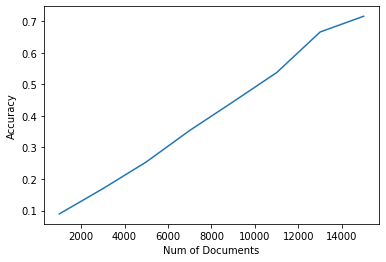

<Figure size 432x288 with 0 Axes>

In [57]:
%matplotlib inline
if __name__ =="__main__":
  path = '20_newsgroups/' 
  demo(path)